The **oxidation enthalpy minimization** problem is defined as the following:
```
Given an oxygen-free compound [original], find the solution X={x_1, x_2, ...} s.t. the free energy change of reaction
[original] + y[oxygen] --> x_1[oxide_1] + x_2[oxide_2] + ... is minimized, where
1. [oxide_1], [oxide_2], ... are potential oxides;
2. y is arbitrary;
3. Elemental conversation is observed.
```

The authors of [Twyman2022](https://pubs.acs.org/doi/10.1021/acs.chemmater.1c02644) proposed a
 greedy algorithm for this problem.
In short, the algorithm calculates `x_i`
sequentially based on the list of `[oxide_i]` sorted by a ranking parameter, which is then defined by
the contribution of `x_i[oxide_i]` to the reaction enthalpy. A detailed description can be found in page 2548 of the article.

In this notebook, we will show that:
1. The original implementation of [Twyman2022](https://pubs.acs.org/doi/10.1021/acs.chemmater.1c02644), as found on
[zenodo](https://zenodo.org/record/5110202#.YlJgpsjMJyg), is not actually a greedy algorithm.
2. The **oxidation enthalpy minimization** problem is a linear optimization problem that can be solved exactly.

## 1. Real greedy

[Twyman2022](https://pubs.acs.org/doi/10.1021/acs.chemmater.1c02644) proposed a ranking parameter defined as the contribution of `x_i[oxide_i]` to the reaction enthalpy. Here is the function to calculate it.

In [1]:
from whygreedy.schema import Compound, is_close_to_zero, np

def calculate_ranking_parameter(oxide: Compound, original: Compound) -> float:
    """
    this is the ranking parameter as defined in the paper, a smaller number indicated the oxide is more favored,
    the one with the smallest ranking parameter will be used to "consume" the original compound
    """
    # If the oxide has an element with > 0 composition, and this element is not present or is of 0 composition in the
    # original compound, then the ranking parameter is inf because it is impossible to consume the original compound
    # with this oxide.
    for e in oxide.elements_exclude_oxygen:
        oxide_composition = oxide.normalized_formula[e]
        original_composition = original.normalized_formula[e]
        if not is_close_to_zero(oxide_composition) and is_close_to_zero(original_composition):
            return np.inf
    p = 0
    for element in oxide.elements:
        if element == "O":
            continue
        c = oxide.normalized_formula[element] / original.normalized_formula[element]
        p += c
    rp = oxide.formation_energy_per_atom / p
    return rp

Now we can implement the greedy algorithm. We will use an argument `real_greedy` to show why the implementation found on
[zenodo](https://zenodo.org/record/5110202#.YlJgpsjMJyg) is not a real greedy algorithm.

In [2]:
from whygreedy.schema import Compound, Tuple, compound_subtract
from copy import deepcopy

def find_greedy(
        oxides: list[Compound], original: Compound, first_choice: int = 0, real_greedy=True
) -> Tuple[list[float], float]:
    # placeholder for the solution
    solution = []
    final_enthalpy = 0.0

    # assign an index for oxides
    for ioxi, oxi in enumerate(oxides):
        oxi.properties["index"] = ioxi

    # we will be updating the original compound, better make a deep copy
    updated_original = deepcopy(original)
    sorted_oxides = oxides  # no need for deep copy

    # init the loop and perform the first greedy ranking
    counter = 0
    sorted_oxides = sorted(sorted_oxides, key=lambda x: calculate_ranking_parameter(x, updated_original))

    while len(solution) < len(oxides):
        if real_greedy:
            # greedy means to find the best in each iteration
            # the implementation found on [zenodo](https://zenodo.org/record/5110202#.YlJgpsjMJyg) does not sort the
            # oxide list at every iteration (only at initialization), so it is not a greedy algorithm
            # this becomes even more problematic considering they used different `first_choice`
            sorted_oxides = sorted(sorted_oxides, key=lambda x: calculate_ranking_parameter(x, updated_original))
        # we can force the first choice to be something else, but always choose the best starting the 2nd iteration
        if counter == 0:
            favored_oxide = sorted_oxides[first_choice]
            index_to_pop = first_choice
        else:
            favored_oxide = sorted_oxides[0]
            index_to_pop = 0
        # once the favored oxide is identified, we can calculate the ratio, and subtract it from the original compound
        ratio, updated_original = compound_subtract(favored_oxide, updated_original)
        # remove the favored oxide from ranking
        sorted_oxides.pop(index_to_pop)
        # update solution
        solution.append((favored_oxide.properties["index"], ratio))
        final_enthalpy += ratio * favored_oxide.formation_energy_per_atom
        # update counter before next iteration
        counter += 1
    solution = sorted(solution, key=lambda x: x[0])
    assert len(solution) == len(oxides)
    return [s[1] for s in solution], final_enthalpy - original.formation_energy_per_atom

Perform tests to make sure our `real_greedy=False` implementation is identical to what we found on [zenodo](https://zenodo.org/record/5110202#.YlJgpsjMJyg).

In [3]:
from whygreedy.Twyman2022ChemMat import find_comp

def find_greedy_old(oxides: list[Compound], original: Compound, first_choice: int = 0) -> Tuple[
    list[float], float]:
    """
    This is just a wrapper for the implementation from 10.1021/acs.chemmater.1c02644
    It is identical to `find_greedy` with `real_greedy` set to False
    """
    stable_oxides = []
    for ioxide, oxide in enumerate(oxides):
        stable_oxide = {
            "nsites": 1,
            # have to make a copy as `find_comp` changes it
            "unit_cell_formula": {k: v for k, v in oxide.normalized_formula.items()},
            "formation_energy_per_atom": oxide.formation_energy_per_atom,
            "index": ioxide,
            "elements": oxide.elements,
        }
        stable_oxides.append(stable_oxide)
    compound_unit_cell = original.normalized_formula

    solution_oxides, final_enthalpy, delta_enthalpy, _, _, _ = find_comp(stable_oxides, compound_unit_cell,
                                                                         original.formation_energy_per_atom, "Oxide",
                                                                         first_choice)
    solution = np.zeros(len(oxides))
    for oxide in solution_oxides:
        solution[oxide["index"]] = oxide["ratio"]
    return solution.tolist(), delta_enthalpy

In [4]:
from itertools import combinations
from whygreedy import check_solution, gen_random_data  # this checks elemental conservation

# define chemical systems
elements = ["A", "B", "C", "D"]
element_combinations = []
for i in range(1, len(elements)+1):
    element_combinations += list(combinations(elements, i))

# generate original-oxides pairs to show
# 1. `find_greedy_old` is identical to `find_greedy` with `real_greedy=False`
# 2. `find_greedy_old` can return results different from `find_greedy` with `real_greedy=True`
seed_max = 1000
print("\t".join(["seed[0-{}]".format(seed_max), "old_implementation", "real_greedy=False", "real_greedy=True"]))
for seed in range(seed_max):
    original, oxides = gen_random_data(["A", "B", "C", "D"], 5, seed)
    dh_old_min = np.inf
    dh_real_min = np.inf
    dh_new_min = np.inf
    for i in range(len(oxides)):
        sol_old, dh_old = find_greedy_old(oxides, original, first_choice=i)
        sol_new, dh_new = find_greedy(oxides, original, first_choice=i, real_greedy=False)
        sol_real, dh_real = find_greedy(oxides, original, first_choice=i, real_greedy=True)

        assert check_solution(sol_new, oxides, original)
        assert check_solution(sol_old, oxides, original)
        assert check_solution(sol_real, oxides, original)

        # confirm we reproduce the old implementation
        assert is_close_to_zero(dh_new - dh_old) and np.allclose(sol_new, sol_old)

        if dh_old < dh_old_min:
            dh_old_min = dh_old
        if dh_new < dh_new_min:
            dh_new_min = dh_new
        if dh_real < dh_real_min:
            dh_real_min = dh_real

    if not is_close_to_zero(dh_new_min - dh_real_min):
        print("{}\t{:.3f}\t{:.3f}\t{:.3f}".format(seed, dh_old_min, dh_new_min, dh_real_min))

seed[0-1000]	old_implementation	real_greedy=False	real_greedy=True
79	-3382.853	-3382.853	-3425.282
80	-2842.212	-2842.212	-2869.699
85	-1492.887	-1492.887	-1477.125
89	-6690.778	-6690.778	-6807.646
287	-1416.526	-1416.526	-1675.765
307	-4913.645	-4913.645	-4902.860
313	-4773.170	-4773.170	-4666.800
437	-1070.313	-1070.313	-1052.178
553	-3611.081	-3611.081	-3599.704
563	-1332.293	-1332.293	-1525.876
914	-2097.586	-2097.586	-2212.100
915	-2156.731	-2156.731	-2139.965
926	-1063.103	-1063.103	-1077.912


While sometimes the "not really greedy" implementation returns the same results as those from "real greedy",
in some cases the difference between them can be large, and not always positive/negative.
One should keep in mind they are all approximate solutions.

## 2. Why greedy, when you can be exact?

Recall our definition of the **oxidation enthalpy minimization** problem.
This is actually a linear optimization problem.
The objective function is the sum `\Sum_i H^f_i * x_i`, `x_i` are all non-negative,
and the feasible region of `X` is constrained by elemental conservation.

In [5]:
import gurobipy as gp
import numpy as np
from gurobipy import GRB

def find_lp(oxides: list[Compound], original: Compound) -> Tuple[list[float], float]:
    # init gurobi model, suppress output
    with gp.Env(empty=True) as env:
        env.setParam('OutputFlag', 0)
        env.setParam('LogToConsole', 0)
        env.start()
        with gp.Model(env=env) as m:

            # add variables
            x = []
            for ioxi, oxi in enumerate(oxides):
                x_i = m.addVar(name=str(ioxi))
                x.append(x_i)

            # add constraints
            c = []
            for e in original.elements:
                element_sum = 0
                for i, x_i in enumerate(x):
                    try:
                        composition = oxides[i].normalized_formula[e]
                    except KeyError:
                        composition = 0
                    element_sum += composition * x_i
                c_e = m.addConstr(element_sum <= original.normalized_formula[e], name=e)
                c.append(c_e)

            # objective function
            objective = 0
            for x_i, oxi in zip(x, oxides):
                objective += x_i * oxi.formation_energy_per_atom

            m.setObjective(objective, GRB.MINIMIZE)
            m.optimize()
            return [v.x for v in m.getVars()], m.objVal - original.formation_energy_per_atom

Now let's compare linear optimization with the greedy method, start with random compounds. We confirm that the linear programming method is always equivalent to or better than greedy algorithms.

In [6]:
n = 1000
n_five_percent_worse = 0
for seed in range(n):
    original, oxides = gen_random_data(["A", "B", "C", "D"], 5, seed)

    sol_old, dh_old = find_greedy_old(oxides, original, first_choice=0)
    sol_real, dh_real = find_greedy(oxides, original, first_choice=0, real_greedy=True)
    sol_exact, dh_exact = find_lp(oxides, original)

    assert check_solution(sol_old, oxides, original)
    assert check_solution(sol_real, oxides, original)
    assert check_solution(sol_exact, oxides, original)

    assert dh_exact <= 0
    # greedy solution should be no better than the exact
    assert dh_exact <= min([dh_real, dh_old]) + 1e-5

    if dh_exact < min([dh_real, dh_old]) * 1.05:
        n_five_percent_worse += 1
print("# of greedy 5% worse than exact: {}".format(n_five_percent_worse))

# of greedy 5% worse than exact: 116


Since the old implementation requires loop over all possible `first_choice`, it is significantly slower than the linear programming method, and gets worse when the # of oxides is large.

In [7]:
original, oxides = gen_random_data(["A", "B", "C", "D"], 5, 42)
print(len(oxides))
%timeit find_lp(oxides, original)
%timeit find_greedy_old(oxides, original, first_choice=0)
%timeit for i in range(len(oxides)) : find_greedy_old(oxides, original, first_choice=i)

75
1.26 ms ± 788 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
258 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
19.4 ms ± 47 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


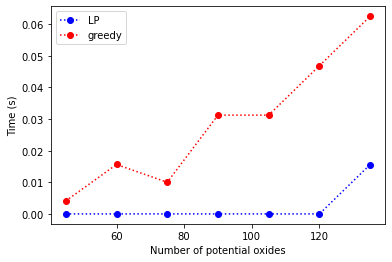

In [8]:
num_oxides_per_chemsys = list(range(3, 10))
import time

def timing(find_function, oxides, original):
    ts1 = time.time()
    if "greedy" in find_function.__name__:
        for i in range(len(oxides)):
            find_function(oxides, original, first_choice=i)
    else:
        find_function(oxides, original)
    ts2 = time.time()
    return ts2 - ts1

time_lp = []
time_greedy = []
num_oxides = []
for n in num_oxides_per_chemsys:
    original, oxides = gen_random_data(["A", "B", "C", "D"], n, 42)
    timing_greedy = timing(find_greedy_old, oxides, original)
    timing_lp = timing(find_lp, oxides, original)
    time_lp.append(timing_lp)
    time_greedy.append(timing_greedy)
    num_oxides.append(len(oxides))

import matplotlib.pylab as plt
fig, ax = plt.subplots()
ax.plot(num_oxides, time_lp, "bo:", label="LP")
ax.plot(num_oxides, time_greedy, "ro:", label="greedy")
ax.set_xlabel("Number of potential oxides")
ax.set_ylabel("Time (s)")
ax.legend()

In [12]:
from whygreedy.mp import load_mp_pairs, compare_greedy_exact, hist_compare
pairs = load_mp_pairs()
dh_diff, quali_diff, solutions_old, solutions_exact = compare_greedy_exact(pairs, greedy_type="old")


100%|██████████| 9238/9238 [00:16<00:00, 546.44it/s]


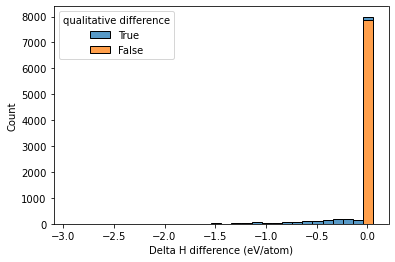

In [13]:
fig = hist_compare(dh_diff, quali_diff, 0)

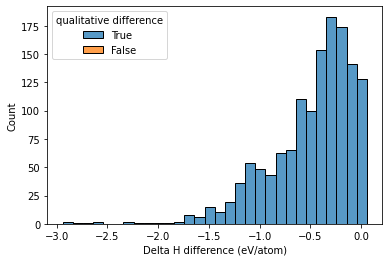

In [14]:
fig.clf()
fig = hist_compare(dh_diff, quali_diff, 1e-5)

In [30]:
# let's look at those with high Delta H difference
def formula_dict_to_string(d:dict):
    return " ".join(["{}{:.3f}".format(k, v) for k, v in d.items()])

def format_solution(oxides: list[Compound], solution:np.ndarray) -> str:
    s = ""
    final = 0
    for i, oxi in zip(solution, oxides):
        if is_close_to_zero(i):
            continue
        s += "\t{:.4f} -- {} -- {:.2f}\n".format(i, formula_dict_to_string(oxi.normalized_formula), oxi.formation_energy_per_atom)
        final += oxi.formation_energy_per_atom * i
    s += "\tenthalpy: {}".format(final)
    return s

for i in range(len(dh_diff)):
    if abs(dh_diff[i]) > 2.5:
        original, oxides = pairs[i]
        print("="*6)
        print("original: " + formula_dict_to_string(original.normalized_formula) + "\t" + original.mpid)
        print("EXACT solution:")
        print(format_solution(oxides, solutions_exact[i]))
        print("GREEDY solution:")
        print(format_solution(oxides, solutions_old[i]))


original: Nb0.625 P0.375	mp-648999
EXACT solution:
	2.4063 -- Nb0.143 P0.143 O0.714 -- -2.94
	1.0938 -- Nb0.257 P0.029 O0.714 -- -3.03
	enthalpy: -10.385870677433038
GREEDY solution:
	2.6250 -- Nb0.143 P0.143 O0.714 -- -2.94
	enthalpy: -7.719580462433038
original: Ta0.667 P0.333	mp-22477
EXACT solution:
	1.4583 -- Ta0.257 P0.029 O0.714 -- -3.31
	2.0417 -- Ta0.143 P0.143 O0.714 -- -3.12
	enthalpy: -11.203598893482141
GREEDY solution:
	2.5926 -- Ta0.257 P0.029 O0.714 -- -3.31
	enthalpy: -8.591994588875659
original: Nb0.636 P0.364	mp-18254
EXACT solution:
	2.3068 -- Nb0.143 P0.143 O0.714 -- -2.94
	1.1932 -- Nb0.257 P0.029 O0.714 -- -3.03
	enthalpy: -10.394334016298703
GREEDY solution:
	2.4747 -- Nb0.257 P0.029 O0.714 -- -3.03
	enthalpy: -7.488362055138888
original: Pr0.333 Al0.667	mp-1189
EXACT solution:
	1.5873 -- Pr0.200 Al0.200 O0.600 -- -3.67
	0.9048 -- Pr0.018 Al0.386 O0.596 -- -3.40
	enthalpy: -8.89803952940476
GREEDY solution:
	1.6667 -- Pr0.200 Al0.200 O0.600 -- -3.67
	enthalpy: -